In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import os

In [2]:
# from tensorflow import keras

In [3]:
import tensorflow as tf

In [4]:
# tf.compat.v1.enable_eager_execution()

In [5]:
path = os.path.join("..", "dane", "clean", "test.csv")

df = pd.read_csv(path)
df.head()

,index,date,time,open,high,low,last,volume,# of trades,ohlc avg,...,middle band,bottom band,obv length,dayfraction,seconds,timestamp_str,timestamp_us,dayofweek,daysinmonth,monthfraction
0,8895,2023-6-15,00:01:10.517003,4418.75,4418.75,4417.00,4417.25,600,482,4417.94,...,4418.50,4417.93,600,0.000816,70.517003,2023-06-15 00:01:10.517003,1686787270517003000,3,30,0.5
1,8896,2023-6-15,00:05:33.982002,4417.25,4417.75,4416.50,4416.50,600,466,4417.00,...,4418.43,4417.73,600,0.003866,333.982002,2023-06-15 00:05:33.982002,1686787533982002000,3,30,0.5
2,8897,2023-6-15,00:12:19.360000,4416.50,4418.25,4416.25,4418.25,600,458,4417.31,...,4418.39,4417.65,600,0.008557,739.360000,2023-06-15 00:12:19.360000,1686787939360000000,3,30,0.5
3,8898,2023-6-15,00:18:57.236000,4418.25,4418.75,4417.50,4418.50,600,492,4418.25,...,4418.37,4417.63,1200,0.013162,1137.236000,2023-06-15 00:18:57.236000,1686788337236000000,3,30,0.5
4,8899,2023-6-15,00:26:32.795000,4418.50,4420.00,4418.50,4420.00,600,457,4419.25,...,4418.42,4417.63,1200,0.018435,1592.795000,2023-06-15 00:26:32.795000,1686788792795000000,3,30,0.5


In [6]:
np.set_printoptions(suppress=False)
pd.set_option('float_format', '{:f}'.format)

In [7]:
tm = df['timestamp_us']
tm = (tm/1e9).values
tm = tm-tm[0]

In [8]:
X = df['last'].values

In [9]:
print(tm.shape, X.shape)

(22796,) (22796,)


In [10]:
tm_uniform = np.arange(tm[0], tm[-1], 1)
X_uniform = np.interp(tm_uniform, tm, X)
print(X_uniform.shape)
X_uniform = X_uniform.reshape(-1, 1)

(1192041,)


In [11]:
# plt.plot(tm[:100], X[:100])
# plt.plot(tm_uniform[:5000], X_uniform[:5000])

In [12]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1)) #Also try QuantileTransformer
X_uniform = scaler.fit_transform(X_uniform)
X_uniform

array([[0.3889902 ],
       [0.38896736],
       [0.38894453],
       ...,
       [0.47312491],
       [0.4731578 ],
       [0.47319069]])

In [13]:
train_size = int(len(X_uniform) * 0.66)
test_size = len(X_uniform) - train_size
train, test = X_uniform[:train_size,:], X_uniform[train_size:,:]

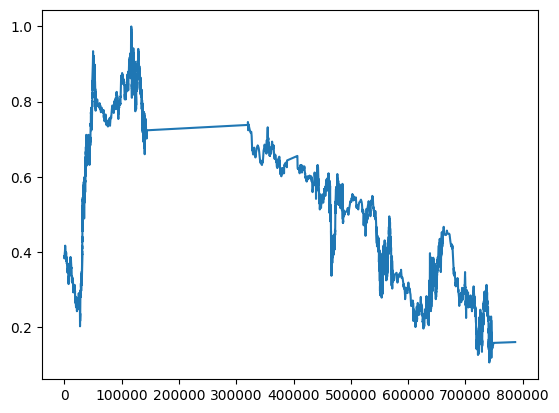

In [14]:
plt.plot(train)

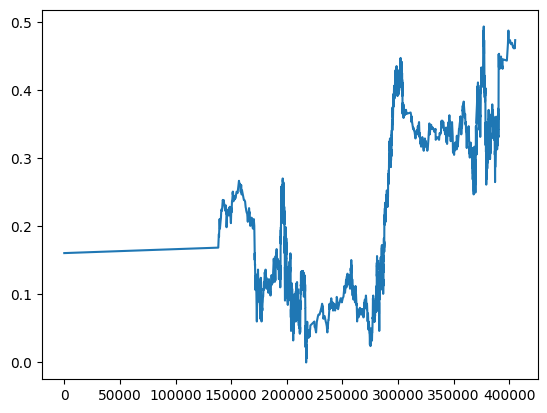

In [15]:
plt.plot(test)

In [16]:
def to_sequences(dataset, seq_size=1):
    x = []
    y = []

    for i in range(len(dataset)-seq_size-1):
        #print(i)
        window = dataset[i:(i+seq_size), 0]
        x.append(window)
        y.append(dataset[i+seq_size, 0])
        
    return np.array(x),np.array(y)
    

seq_size = 120  # Number of time steps to look back 
#Larger sequences (look further back) may improve forecasting.

trainX, trainY = to_sequences(train, seq_size)
testX, testY = to_sequences(test, seq_size)

trainX.shape, trainY.shape, testX.shape, testY.shape

((786626, 120), (786626,), (405173, 120), (405173,))

In [17]:
trainX = trainX.reshape((trainX.shape[0],  1, seq_size))
testX = testX.reshape((testX.shape[0],  1, seq_size))
trainX.shape, testX.shape

((786626, 1, 120), (405173, 1, 120))

In [18]:
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LSTM, Flatten
# from keras.layers import ConvLSTM2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, Flatten
from tensorflow.keras.layers import ConvLSTM2D

In [19]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(f"Gpus: {gpus}")
# tf.config.experimen

Gpus: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [20]:
# config = tf.compat.v1.ConfigProto(device_count = {'GPU': 1})
# config.gpu_options.per_process_gpu_memory_fraction = 0.8
# tf.compat.v1.InteractiveSession(config=config)

In [21]:
# # tf.config.experimental.set_virtual_device_configuration(
# #     gpus[0],
# #     [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5000)])

# config = tf.compat.v1.ConfigProto(device_count = {'GPU': 1})
# sess = tf.compat.v1.Session(config=config)
# # dir(sess)

In [22]:
with tf.compat.v1.Session():
    model = Sequential()
    model.add(LSTM(250, return_sequences=True, input_shape=(1,seq_size)))
    # model.add(LSTM(50))
    model.add(Dense(32))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    model.fit(trainX, trainY, validation_data=(testX, testY),
          verbose=True, epochs=1)

Train on 786626 samples, validate on 405173 samples
786626/786626 [==============================] - ETA: 0s - loss: 0.0447

C:\Users\Greg\anaconda3\envs\tf2\lib\site-packages\keras\engine\training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


786626/786626 [==============================] - 192s 244us/sample - loss: 0.0447 - val_loss: 0.1270


In [23]:
# model = Sequential()
# model.add(LSTM(250, return_sequences=True, input_shape=(1,seq_size)))
# # model.add(LSTM(50))
# model.add(Dense(32))
# model.add(Dense(1))
# model.compile(optimizer='adam', loss='mean_squared_error')

In [24]:
model = Sequential()
model.add(LSTM(250, return_sequences=True, input_shape=(1,seq_size)))
# model.add(LSTM(50))
model.add(Dense(32))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(trainX, trainY, validation_data=(testX, testY),
      verbose=True, epochs=1)


KeyboardInterrupt



In [ ]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
trainPredict.shape, testPredict.shape

In [ ]:
trainPredict = scaler.inverse_transform(trainPredict.reshape(-1,1))
trainY = scaler.inverse_transform(trainY.reshape(-1,1))
testPredict = scaler.inverse_transform(testPredict.reshape(-1,1))
testY = scaler.inverse_transform(testY.reshape(-1,1))

In [ ]:
trainPredict.shape, trainY.shape, testPredict.shape, testY.shape

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

In [ ]:
plt.plot(testPredict)

In [ ]:
plt.plot(testY)